# spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [1]:
# 필요한 모듈 불러오기
import pandas as pd
import numpy as np

from gensim.models import Word2Vec, FastText

import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Load Data
- 보시면 spam.csv는 라벨이 있는 데이터예요. 물론 8주차 주체가 텍스트 기초인만큼 텍스트만 활용하셔도 되고 라벨까지 활용하셔서 모델을 돌려볼 수도 있어요!

In [2]:
spam = pd.read_csv('./spam.csv')

corpus가 작기 때문에 모두 소문자로 바꿔서 한번씩만 나오는 단어들을 최소화한다.

In [3]:
spam['v2'] = spam['v2'].str.lower()

In [4]:
spam.iloc[5]['v2']

"freemsg hey there darling it's been 3 week's now and no word back! i'd like some fun you up for it still? tb ok! xxx std chgs to send, å£1.50 to rcv"

In [5]:
spam.head()

,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [6]:
spam.shape

(5572, 2)

In [7]:
spam['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [8]:
spam.isnull().sum()

v1    0
v2    0
dtype: int64

In [9]:
spam['v2'].describe()

count                       5572
unique                      5168
top       sorry, i'll call later
freq                          30
Name: v2, dtype: object

In [10]:
spam['v2'].str.len().describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: v2, dtype: float64

* 4825개의 일반 텍스트, 747개의 스팸 텍스트로 이루어진 총 5572개의 데이터이다.
* null 값은 없다.
* 텍스트의 평균 길이는 80, 최소 길이는 2, 최대 길이는 910이다.
* 텍스트 중 유니크한 것은 총 5168개이므로 중복되는 텍스트들이 있다. "sorry, i'll call later"은 30번이 반복되었다. 따라서 중복되는 것들은 제외한다.

In [11]:
spam = spam.drop_duplicates('v2')
len(spam)

5168

## Tokenizing
- 실습코드는 물론 한국어 대상이라 konlpy를 다뤘지만, 슬라이드 보시면 영어는 nltk 모듈을 쓸 수 있어요. 의미 있는 토큰으로 쪼개고 불용어도 처리해보세요! 현존하는 불용어 리스트를 사용해도 좋고, 새롭게 만들어도 좋을 것 같아요!

### 불용어 확인

In [12]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 토큰 생성 (tokenize)

In [13]:
spam['words'] = spam['v2'].apply(nltk.tokenize.word_tokenize)
spam['words']

0       [go, until, jurong, point, ,, crazy, .., avail...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [this, is, the, 2nd, time, we, have, tried, 2,...
5568     [will, ì_, b, going, to, esplanade, fr, home, ?]
5569    [pity, ,, *, was, in, mood, for, that, ., so, ...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                  [rofl, ., its, true, to, its, name]
Name: words, Length: 5168, dtype: object

### 불용어 제외

In [14]:
spam['words_wo_stopwords'] = spam['words'].apply(lambda words: [x for x in words if x not in stopwords])
spam['words_wo_stopwords']

0       [go, jurong, point, ,, crazy, .., available, b...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3       [u, dun, say, early, hor, ..., u, c, already, ...
4       [nah, n't, think, goes, usf, ,, lives, around,...
                              ...                        
5567    [2nd, time, tried, 2, contact, u., u, å£750, p...
5568               [ì_, b, going, esplanade, fr, home, ?]
5569           [pity, ,, *, mood, ., ..., suggestions, ?]
5570    [guy, bitching, acted, like, 'd, interested, b...
5571                                [rofl, ., true, name]
Name: words_wo_stopwords, Length: 5168, dtype: object

### 어간 추출 (stemming)

In [15]:
stemmer = nltk.stem.PorterStemmer()
spam['stem'] = spam['words'].apply(lambda words: [stemmer.stem(w) for w in words])
spam['stem']

0       [go, until, jurong, point, ,, crazi, .., avail...
1                  [ok, lar, ..., joke, wif, u, oni, ...]
2       [free, entri, in, 2, a, wkli, comp, to, win, f...
3       [u, dun, say, so, earli, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goe, to, usf, ,, ...
                              ...                        
5567    [thi, is, the, 2nd, time, we, have, tri, 2, co...
5568         [will, ì_, b, go, to, esplanad, fr, home, ?]
5569    [piti, ,, *, wa, in, mood, for, that, ., so, ....
5570    [the, guy, did, some, bitch, but, i, act, like...
5571                    [rofl, ., it, true, to, it, name]
Name: stem, Length: 5168, dtype: object

### 품사 부착 (pos tagging)

In [16]:
spam['pos'] = spam['words'].apply(nltk.tag.pos_tag)
spam['pos']

0       [(go, VB), (until, IN), (jurong, JJ), (point, ...
1       [(ok, JJ), (lar, NN), (..., :), (joking, VBG),...
2       [(free, JJ), (entry, NN), (in, IN), (2, CD), (...
3       [(u, JJ), (dun, NNS), (say, VBP), (so, RB), (e...
4       [(nah, NN), (i, NNS), (do, VBP), (n't, RB), (t...
                              ...                        
5567    [(this, DT), (is, VBZ), (the, DT), (2nd, JJ), ...
5568    [(will, MD), (ì_, VB), (b, NN), (going, VBG), ...
5569    [(pity, NN), (,, ,), (*, NN), (was, VBD), (in,...
5570    [(the, DT), (guy, NN), (did, VBD), (some, DT),...
5571    [(rofl, NN), (., .), (its, PRP$), (true, JJ), ...
Name: pos, Length: 5168, dtype: object

### 원형 복원 (lemmatize)

In [17]:
# https://stackoverflow.com/a/46564234

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
lm = nltk.stem.WordNetLemmatizer()
spam['lemma'] = spam['pos'].apply(lambda pairs: [lm.lemmatize(w, pos=get_wordnet_pos(p)) for w, p in pairs])
spam['lemma']

0       [go, until, jurong, point, ,, crazy, .., avail...
1                  [ok, lar, ..., joke, wif, u, oni, ...]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, go, to, usf, ,, h...
                              ...                        
5567    [this, be, the, 2nd, time, we, have, try, 2, c...
5568        [will, ì_, b, go, to, esplanade, fr, home, ?]
5569    [pity, ,, *, be, in, mood, for, that, ., so, ....
5570    [the, guy, do, some, bitching, but, i, act, li...
5571                    [rofl, ., it, true, to, it, name]
Name: lemma, Length: 5168, dtype: object

### 추출 결과 확인

In [19]:
spam.head()

,v1,v2,words,words_wo_stopwords,stem,pos,lemma
0,ham,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail...","[go, jurong, point, ,, crazy, .., available, b...","[go, until, jurong, point, ,, crazi, .., avail...","[(go, VB), (until, IN), (jurong, JJ), (point, ...","[go, until, jurong, point, ,, crazy, .., avail..."
1,ham,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joke, wif, u, oni, ...]","[(ok, JJ), (lar, NN), (..., :), (joking, VBG),...","[ok, lar, ..., joke, wif, u, oni, ...]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, in, 2, a, wkli, comp, to, win, f...","[(free, JJ), (entry, NN), (in, IN), (2, CD), (...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, ..., u, c, alrea...","[u, dun, say, early, hor, ..., u, c, already, ...","[u, dun, say, so, earli, hor, ..., u, c, alrea...","[(u, JJ), (dun, NNS), (say, VBP), (so, RB), (e...","[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,ham,"nah i don't think he goes to usf, he lives aro...","[nah, i, do, n't, think, he, goes, to, usf, ,,...","[nah, n't, think, goes, usf, ,, lives, around,...","[nah, i, do, n't, think, he, goe, to, usf, ,, ...","[(nah, NN), (i, NNS), (do, VBP), (n't, RB), (t...","[nah, i, do, n't, think, he, go, to, usf, ,, h..."


In [20]:
for i in spam.index[:5]:
    for j in spam.columns:
        print(j, ':', spam.loc[i, j])
    print('')

v1 : ham
v2 : go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
words : ['go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']
words_wo_stopwords : ['go', 'jurong', 'point', ',', 'crazy', '..', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'got', 'amore', 'wat', '...']
stem : ['go', 'until', 'jurong', 'point', ',', 'crazi', '..', 'avail', 'onli', 'in', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amor', 'wat', '...']
pos : [('go', 'VB'), ('until', 'IN'), ('jurong', 'JJ'), ('point', 'NN'), (',', ','), ('crazy', 'JJ'), ('..', 'NN'), ('available', 'JJ'), ('only', 'RB'), ('in', 'IN'), ('bugis', 'NN'), ('n', 'RB'), ('great', 'JJ'), ('world', 'NN'), ('la', 'NN'), ('e', 'FW'), ('buffet', 'NN'), ('...', ':'), ('cine', 'NN'), ('t

## Embedding + 해석

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었어요. 왜 이 임베딩 모델을 적용하게 되었는지 '비교' 결과와 함께 적어주세요!

In [21]:
def flatten(l):
    return [y for x in l for y in x]

In [22]:
corpus = spam['words_wo_stopwords'].values
print('총 단어 개수:', len(flatten(corpus)))
print('총 유니크한 단어 개수:', len(set(flatten(corpus))))

총 단어 개수: 63291
총 유니크한 단어 개수: 9341


### 어떤 단어가 ham보다 spam에 더 많이 나오는가? (또는 spam보다 ham에 더 많이 나오는가?)

In [23]:
wordcloud = WordCloud()

In [24]:
corpus_words = flatten(corpus)
pos = spam[spam['v1']=='spam']
pos_words = flatten(pos['words_wo_stopwords'].values)
neg = spam[spam['v1']!='spam']
neg_words = flatten(neg['words_wo_stopwords'].values)

corpus_freq = pd.Series(corpus_words).value_counts()
pos_freq = pd.Series(pos_words).value_counts()
neg_freq = pd.Series(neg_words).value_counts()

In [25]:
def draw_wordcloud(text, title):
    wc = wordcloud.generate(text)
    plt.figure(figsize=(22,22)) #이미지 사이즈 지정
    plt.title(title)
    plt.imshow(wordcloud, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거

### 전체 Corpus

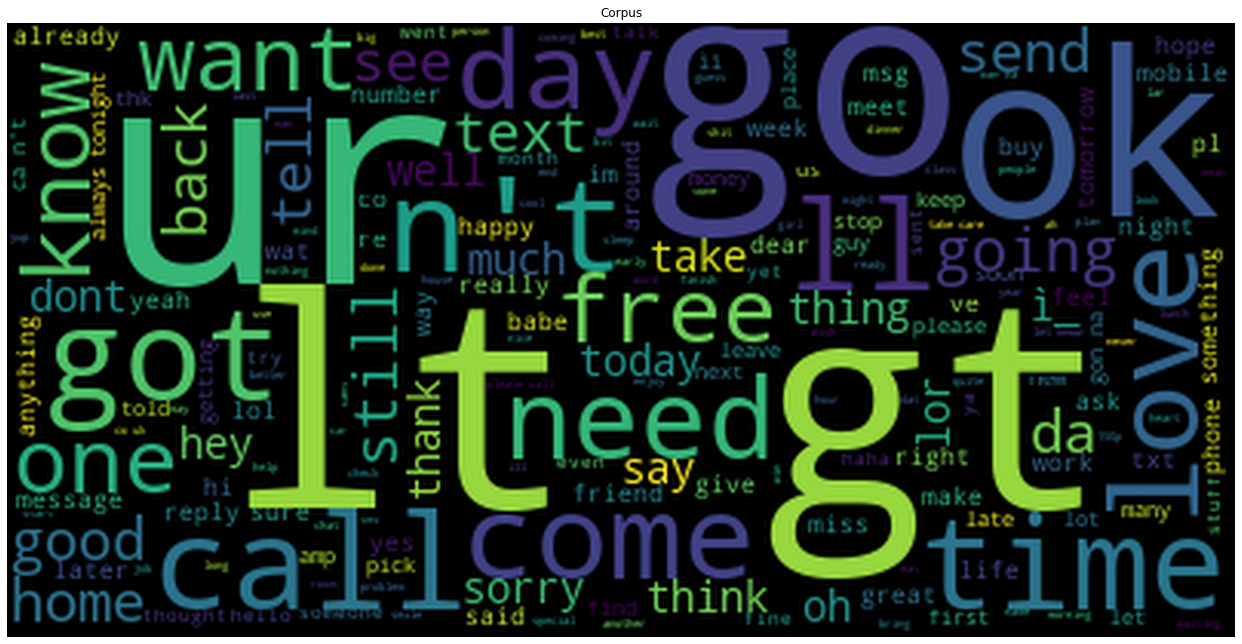

In [26]:
draw_wordcloud(' '.join(corpus_words), 'Corpus')

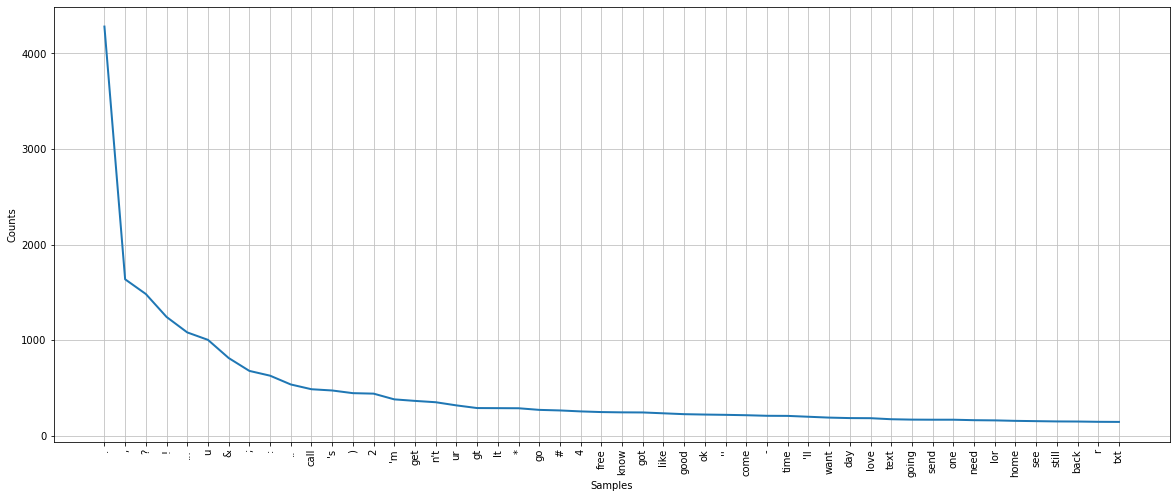

In [27]:
plt.figure(figsize=(20, 8))
nltk.Text(corpus_words).plot(50)
plt.show()

### Spam 단어들

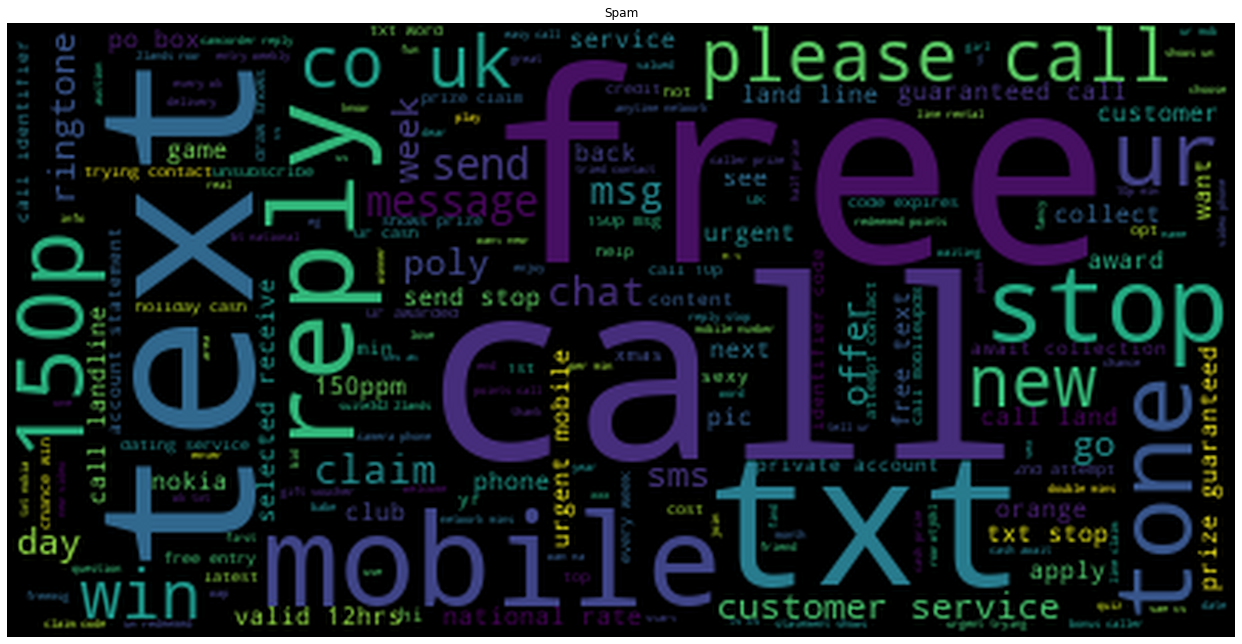

In [28]:
draw_wordcloud(' '.join(pos_words), 'Spam')

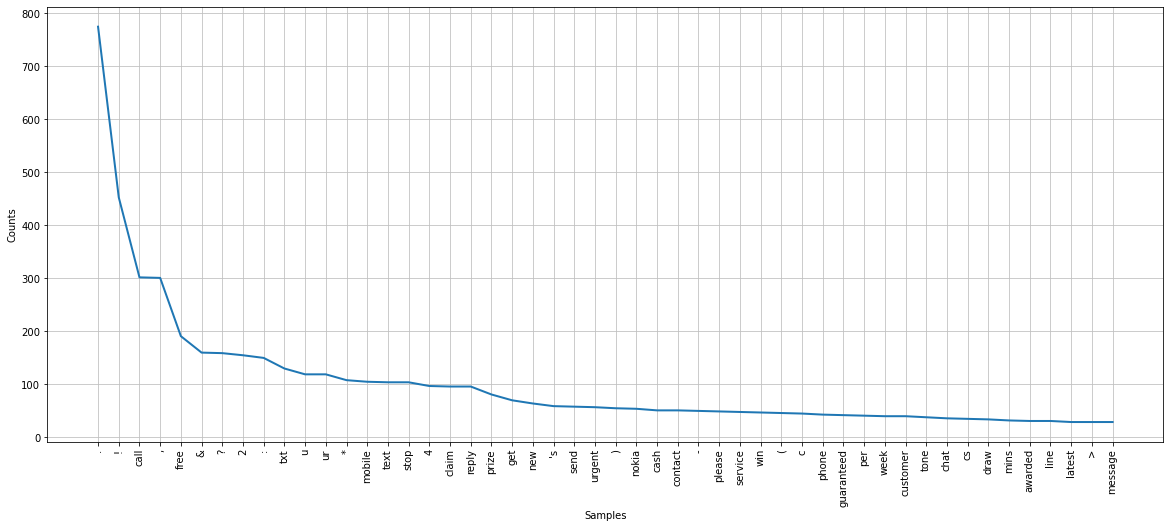

In [29]:
plt.figure(figsize=(20, 8))
pos_text = nltk.Text(pos_words) 
pos_text.plot(50)
plt.show()

### Ham 단어들

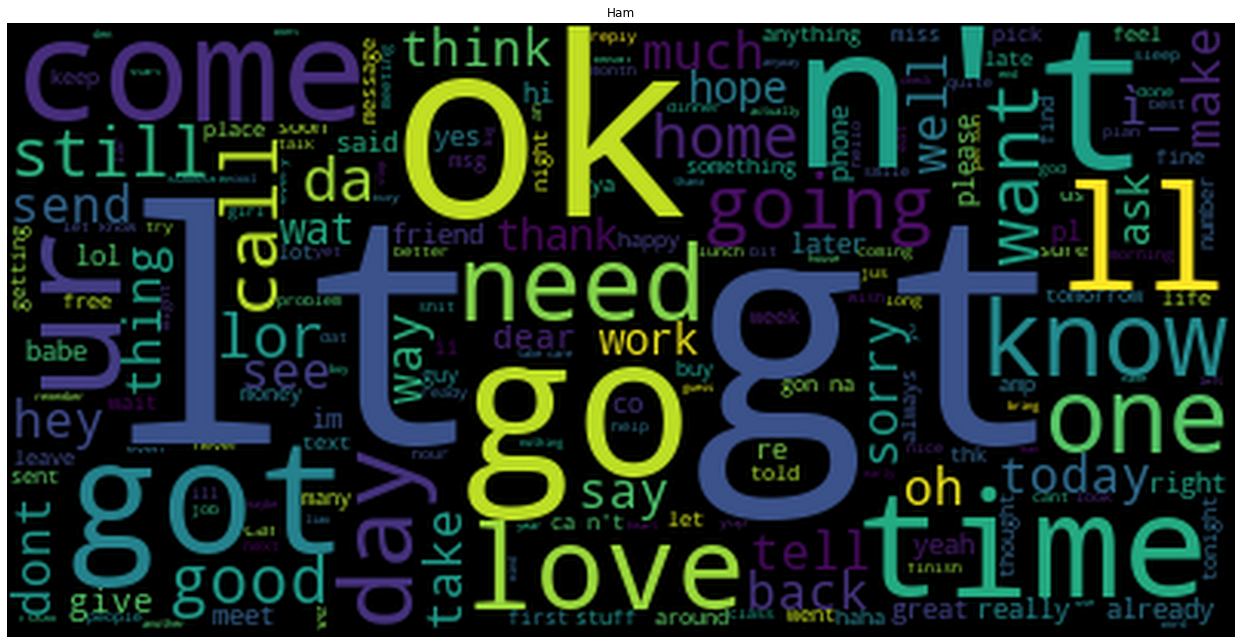

In [30]:
draw_wordcloud(' '.join(neg_words), 'Ham')

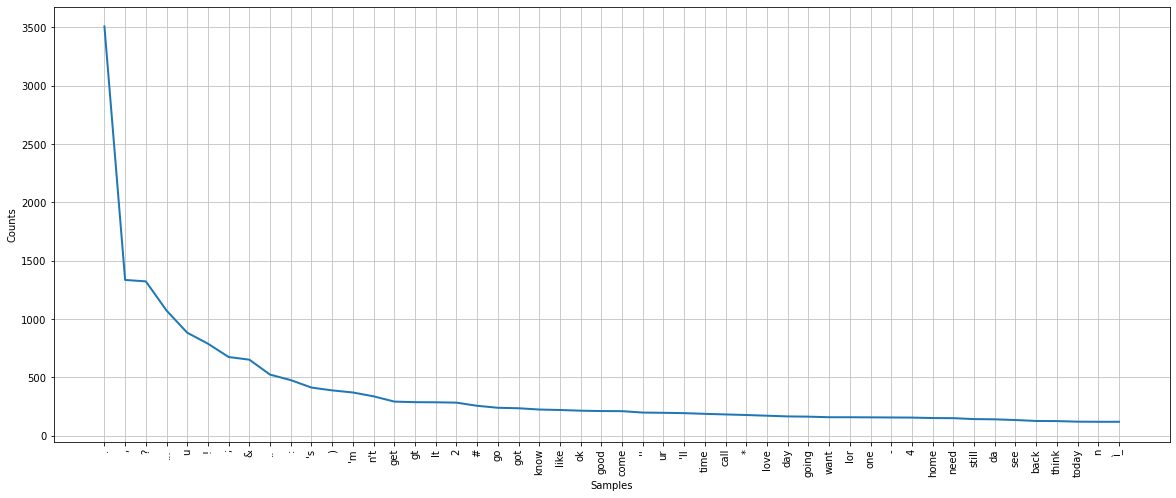

In [31]:
plt.figure(figsize=(20, 8))
nltk.Text(neg_words).plot(50)
plt.show()

## 인사이트 1

spam에 자주 등장하는 단어들과 ham에 자주등장하는 단어들에 차이가 있다. 특히 spam에 'free', 'call', 'text', 'mobile' 등이 자주 등장함을 볼 수 있다.

---

이제 이 단어들이 어떤 문맥에서 사용되는지 확인해보겠다.

In [32]:
pos_text.concordance("free")

Displaying 25 of 191 matches:
 free entry 2 wkly comp win fa cup final t
 update latest colour mobiles camera free ! call mobile update co free 0800298
 camera free ! call mobile update co free 08002986030 six chances win cash ! 1
pply reply hl 4 info urgent ! 1 week free membership å£100,000 prize jackpot !
r burns - msg = tried call reply sms free nokia mobile + free camcorder . plea
d call reply sms free nokia mobile + free camcorder . please call 08000930705 
rman v , matrix3 , starwars3 , etc 4 free ! bx420-ip4-5we . 150pm . dont miss 
uaranteed å£1000 cash å£5000 prize ! free ringtone waiting collected . simply 
p.msg @ 150p 'll rcv msgs chat svc . free hardcore services text go : 69988 u 
n ? ur career 2 flyng start ? 2 find free , txt horo followed ur star sign , e
500 cd vouchers 125gift guaranteed & free entry 2 100 wkly draw txt music 8706
698 ur ringtone service changed ! 25 free credits ! go club4mobiles.com choose
hoose top quality ringtone ! message free charge . hmv bon

In [33]:
pos_text.concordance("call")

Displaying 25 of 302 matches:
 receivea å£900 prize reward ! claim call 09061701461. claim code kl341 . vali
 latest colour mobiles camera free ! call mobile update co free 08002986030 si
2584351 - rodger burns - msg = tried call reply sms free nokia mobile + free c
kia mobile + free camcorder . please call 08000930705 delivery tomorrow sms . 
ats ! 1 year special cinema pass 2 . call 09061209465 ! c suprman v , matrix3 
w mob . awarded å£1500 bonus prize , call 09066364589 urgent ur awarded compli
 '' ? comes ken 's stuff ! '' please call customer service representative 0800
draw shows å£1000 prize guaranteed . call 09064012160. claim code k52 . valid 
 786 unredeemed bonus points . claim call 08719180248 identifier code : 45239 
r prize 5/9/03 final try contact u ! call landline 09064019788 box42wr29c , 15
d receive $ 350 award . match please call 08712300220 quoting claim code 4041 
 new years delivery waiting . please call 07046744435 arrange delivery winner 
 draw shows å£900 priz

In [34]:
pos_text.concordance("text")

Displaying 25 of 104 matches:
win fa cup final tkts 21st may 2005. text fa 87121 receive entry question ( st
 ringtone waiting collected . simply text password \mix\ '' 85069 verify . get
gs chat svc . free hardcore services text go : 69988 u get nothing u must age 
yr network & try freemsg n't replied text ? 'm randy , sexy , female live loca
owed ur star sign , e. g. horo aries text & meet someone sexy today . u find d
50 anytime networks mins ? unlimited text ? camcorder ? reply call 08000930705
hey really horny want chat see naked text hot 69698 text charged 150pm unsubsc
y want chat see naked text hot 69698 text charged 150pm unsubscribe text stop 
69698 text charged 150pm unsubscribe text stop 69698 ur ringtone service chang
 babes sport , keep mobile fit funky text wap 82468 think ur smart ? win å£200
smart ? win å£200 week weekly quiz , text play 85222 ! & cs winnersclub po box
67 update ! or2stoptxt free ringtone text first 87131 poly text get 87131 true
 free ringtone text fi

In [35]:
pos_text.concordance("mobile")

Displaying 25 of 105 matches:
claim code kl341 . valid 12 hours . mobile 11 months ? u r entitled update lat
t colour mobiles camera free ! call mobile update co free 08002986030 six chan
16+ thanks subscription ringtone uk mobile charged å£5/month please confirm re
g = tried call reply sms free nokia mobile + free camcorder . please call 0800
ifier code : 45239 expires urgent ! mobile . awarded å£2000 bonus caller prize
tent . u , goto wap . bangb . tv ur mobile internet/service menu urgent ! tryi
ingtone club : get uk singles chart mobile week choose top quality ringtone ! 
tones , gossip , babes sport , keep mobile fit funky text wap 82468 think ur s
3uz . 16+ . gbp1.50/week december ! mobile 11mths+ ? entitled update latest co
ntitled update latest colour camera mobile free ! call mobile update co free 0
st colour camera mobile free ! call mobile update co free 08002986906 call ger
032124 . pobox12n146tf150p urgent ! mobile number awarded å£2000 prize guarant
t.com renewal pin tgxx

## 인사이트 2

* free: 상품이나 서비스를 팔려고 하거나 혜택을 주겠다는 문맥에서 자주 쓰임을 확인할 수 있다.
* call: 전화번호와 함께 쓰여 서비스 이용을 위해 전화해달라는 문맥에서 자주 쓰임을 확인할 수 있다.
* text: 서비스 이용을 위해 문자해달라는 문맥에서 자주 쓰임을 확인할 수 있다. 앞뒤로 단어들이 무작위로 나열되어 있어 해석하기도 힘들다.
* mobile: 핸드폰이나 요금제, 관련 서비스를 팔려고 하거나 연락해달라고 하는 문맥에서 자주 쓰임을 확인할 수 있다.

### `freq_ratio` 계산

이제 전체에서 10번 이상 나온 토큰에 대해 `freq_ratio = (spam corpus에서 나오는 횟수) / (전체 corpus에서 나오는 횟수)`를 계산해보겠다. `freq_ratio`가 높을수록 `ham`보다 `spam`에 자주 등장하는 토큰이고 `freq_ratio`가 낮을수록 `spam`보다 `ham`에 자주 등장하는 토큰이다.

In [36]:
freq_ratio = (pos_freq/corpus_freq[corpus_freq>=10]).dropna().sort_values()

In [37]:
freq_ratio.head(30)

;          0.002954
...        0.006481
k          0.009259
much       0.009259
oh         0.009346
come       0.009390
wat        0.009709
way        0.010417
happy      0.010526
already    0.010989
yeah       0.011494
really     0.011905
e          0.012821
home       0.012987
'll        0.015228
wait       0.016393
thing      0.016393
ca         0.017241
ya         0.017544
late       0.017857
going      0.017964
things     0.020000
..         0.020561
....       0.020833
'm         0.021108
thought    0.022222
ok         0.022727
stuff      0.022727
#          0.022814
ill        0.023810
dtype: float64

In [38]:
freq_ratio.tail(30)

txts             1.0
cs               1.0
eg               1.0
complimentary    1.0
collection       1.0
bonus            1.0
tones            1.0
tone             1.0
claim            1.0
charged          1.0
awarded          1.0
prize            1.0
entry            1.0
freemsg          1.0
http             1.0
weekly           1.0
500              1.0
guaranteed       1.0
750              1.0
8007             1.0
expires          1.0
86688            1.0
rental           1.0
>                1.0
ringtone         1.0
vouchers         1.0
sae              1.0
valid            1.0
87066            1.0
å£5000           1.0
dtype: float64

In [39]:
ham_tokens = freq_ratio.head(30).index
spam_tokens = freq_ratio.tail(30).index

`skipgram`, `cbow` 방식으로 `word2vec`, `fasttext` embedding을 하여, 각 embedding된 벡터들로 위 단어들과 가까운 단어를 similarity로 찾아보겠다. `spam_tokens`와 가까운 토큰으로 판별된 토큰의 `freq_ratio`가 높고, `ham_tokens`와 가까운 토큰으로 판별된 토큰의 `freq_ratio`가 낮으면 좋은 embedding일 것이다. 반대라면 spam classification task에 대해서 안좋은 embedding일 것이다.

`size=16, window=3, min_count=10`로 하이퍼파라미터를 맞추어 동일선상에서 비교하겠다.

In [40]:
def get_top5_similar_freq_ratios(model, token):
    res = []
    for token, score in model.wv.most_similar(token, topn=5):
        if token in freq_ratio.index:
            res.append(freq_ratio.loc[token])
    return res

def score_model(model, ham_tokens, spam_tokens):
    ham_score = np.mean(flatten([get_top5_similar_freq_ratios(model, token) for token in ham_tokens]))
    spam_score = np.mean(flatten([get_top5_similar_freq_ratios(model, token) for token in spam_tokens]))
    return ham_score, spam_score

score_board = pd.DataFrame(index=['word2vec_skipgram', 'word2vec_cbow', 'fasttext_skipgram', 'fasttext_cbow'], columns=['ham_score', 'spam_score'])

### Word2Vec(Skipgram)

In [41]:
word2vec_skipgram_model = Word2Vec(corpus, size=16, window=3, min_count=10, workers=1, sg=0)
score_board.loc['word2vec_skipgram'] = score_model(word2vec_skipgram_model, ham_tokens, spam_tokens)

### Word2Vec(Cbow)

In [42]:
word2vec_cbow_model = Word2Vec(corpus, size=16, window=3, min_count=10, workers=1, sg=1)
score_board.loc['word2vec_cbow'] = score_model(word2vec_cbow_model, ham_tokens, spam_tokens)

### FastText(Skipgram)

In [43]:
fasttext_skipgram_model = FastText(corpus, size=16, window=3, min_count=10, workers=1, sg=0)
score_board.loc['fasttext_skipgram'] = score_model(fasttext_skipgram_model, ham_tokens, spam_tokens)

### FastText(Cbow)

In [44]:
fasttext_cbow_model = FastText(corpus, size=16, window=3, min_count=10, workers=1, sg=1)
score_board.loc['fasttext_cbow'] = score_model(fasttext_cbow_model, ham_tokens, spam_tokens)

### 결과

In [45]:
score_board

,ham_score,spam_score
word2vec_skipgram,0.114735,0.429517
word2vec_cbow,0.0690185,0.829722
fasttext_skipgram,0.170552,0.69127
fasttext_cbow,0.0692435,0.845169


In [46]:
score_board['spam_score']-score_board['ham_score']

word2vec_skipgram    0.314781
word2vec_cbow        0.760703
fasttext_skipgram    0.520718
fasttext_cbow        0.775925
dtype: object

`ham_score`은 `ham`에 자주등장한 토큰들에 가까운 토큰들의 `freq_ratio`의 평균이고, `spam_score`은 `spam`에 자주등장한 토큰들에 가까운 토큰들의 `freq_ratio`의 평균이다. 따라서 `ham_score`은 낮을수록 좋고, `spam_score`은 높을수록 좋다. 

## 인사이트 3
두 값 간의 차를 비교했을 때, `cbow`를 활용한 `fasttext`이 이 비교 방법에서는 가장 좋음을 알 수 있다. 또한 `cbow`가 `skipgram`보다 이 비교 방법에서는 우월했다. 따라서 이후에 spam classification을 할 때 `cbow fasttext` embedding 사용을 우선적으로 고려해볼 수도 있다.